# Import

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Pregunta 1

In [ ]:
cmg_real = pd.read_csv("costo_marginal_real.csv")
cmg_real.head()

In [ ]:
cmg_previsto = pd.read_csv("costo_marginal_programado.csv")
cmg_previsto.head()

In [ ]:
costo_marginal = cmg_real.merge(cmg_previsto, left_on=["barra_mnemotecnico","fecha","hora"], right_on=["mnemotecnico_barra","fecha","hora"]).drop(columns=["mnemotecnico_barra","nombre_barra"])
costo_marginal.rename(columns={"costo_en_dolares":"costo_real_usd", "costo":"costo_previsto_usd"}, inplace=True)
costo_marginal.head()

## Análisis exploratorio

In [ ]:
sum(costo_marginal.hora==25)

In [ ]:
costo_marginal = costo_marginal[costo_marginal.hora<25]
costo_marginal = costo_marginal.drop_duplicates(subset=["barra_mnemotecnico","fecha","hora"], keep='last')

In [ ]:
costo_marginal.describe()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=costo_marginal.costo_real_usd, name="cmg_real"))
fig.add_trace(go.Histogram(x=costo_marginal.costo_previsto_usd, name="cmg_previsto"))
fig.update_layout(barmode="overlay")
fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
costo_marginal.groupby("barra_mnemotecnico")["costo_real_usd"].sum()

In [ ]:
costo_marginal.nunique()

In [ ]:
cmg_real.nunique()

In [ ]:
costo_marginal.fecha.agg(["min", "max"])

In [ ]:
costo_marginal = costo_marginal.sort_values(["barra_mnemotecnico","fecha","hora"])
costo_marginal["datetime"] = pd.to_datetime(costo_marginal.fecha) + costo_marginal.hora.astype('timedelta64[h]')
costo_marginal.set_index("datetime", inplace=True)

# Respuesta P1
Supuestos: 
- Se eliminaron 212 filas anómalas, esto porque el campo de hora era igual a 25.
- También se eliminaron filas con valores duplicados para la combinación (barra, fecha, hora). 

Respuesta:
Se programa el costo marginal para el 21,6% de las barras, equivalente a 220 de 1.020. 
La data corresponde a los 6 primeros meses del 2019, sin embargo, no todas las barras tienen información para todo el periodo.
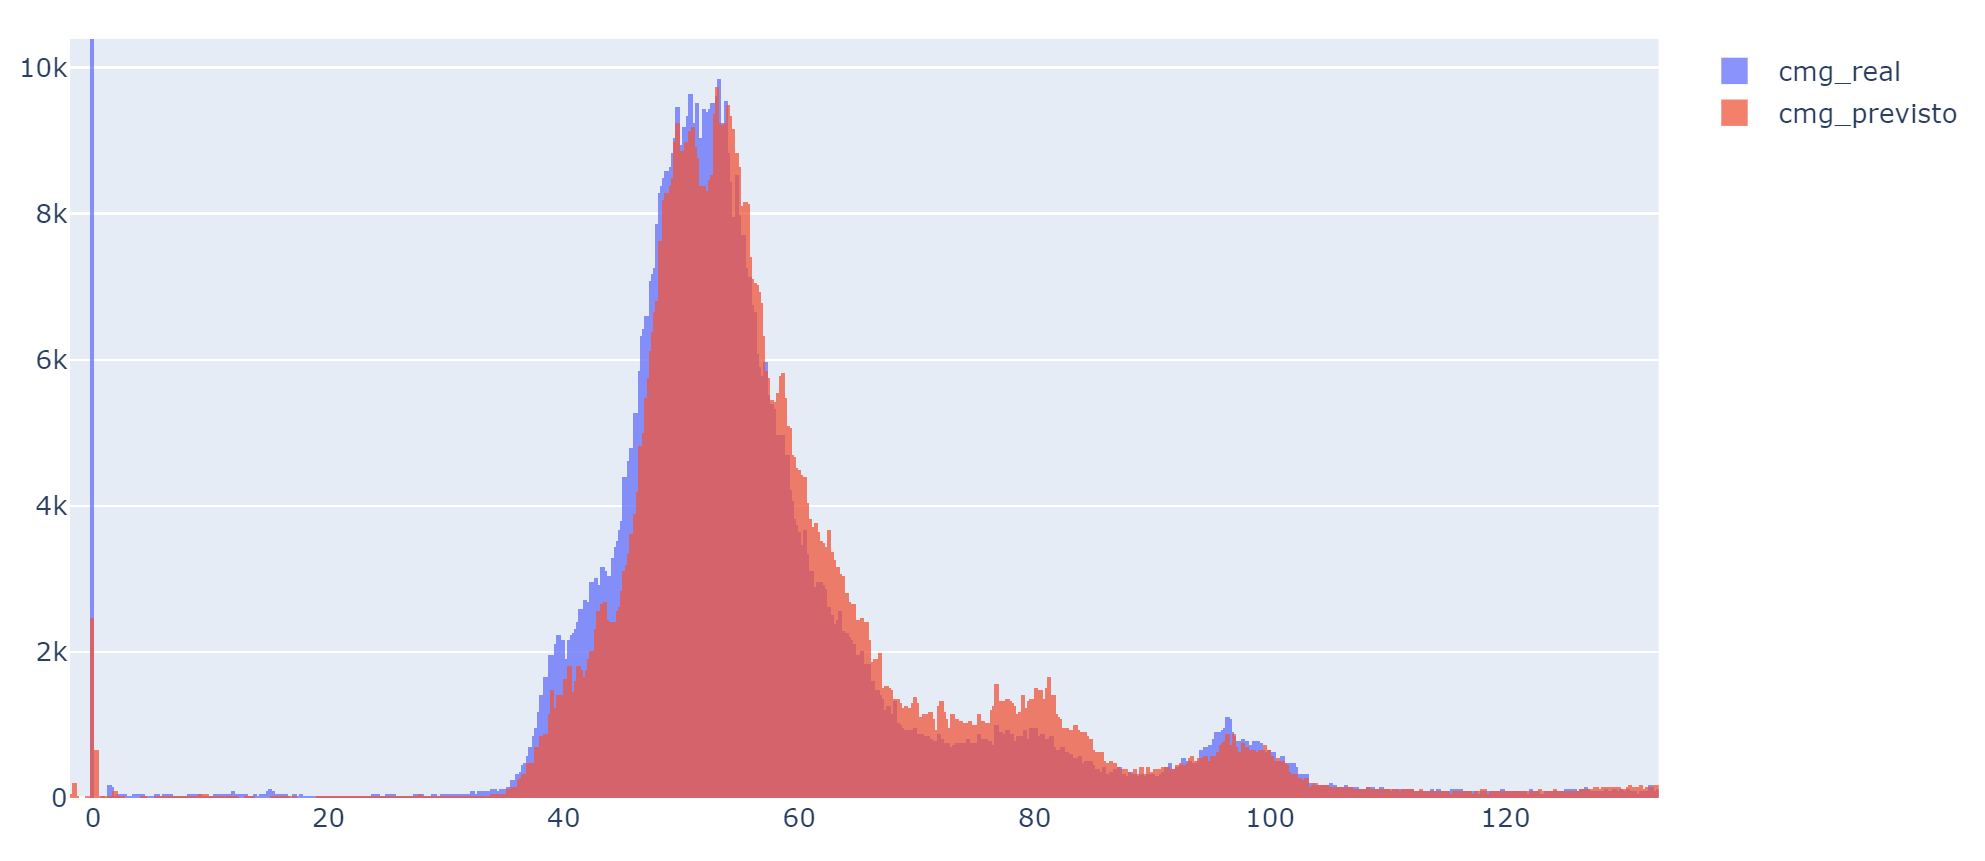
Se observa que tanto el costo real como el previsto siguen una distribución similar, a primera vista podria ser chi2 o lognormal, pero debiesemos hacer un test de hipótesis para asegurarlo.
Adicionalmente, hay muchas instancias en la que el costo marginal es cero, probablemente se debe a barras que generan energía renovable o también en horas de muy baja demanda y mucha oferta.

# Pregunta 2

In [ ]:
costo_marginal["desviacion"] = costo_marginal.costo_real_usd - costo_marginal.costo_previsto_usd
costo_marginal["desviacion_pct"] = (costo_marginal.costo_real_usd/costo_marginal.costo_previsto_usd-1)*100
costo_marginal["desviacion_cat"] = [1 if abs(x)>15 else 0 for x in costo_marginal.desviacion_pct]
costo_marginal.head()


In [ ]:
costo_marginal.describe()
costo_marginal.replace(np.inf, np.nan, inplace=True) 
costo_marginal.describe()

In [ ]:
graph_data = costo_marginal.groupby(costo_marginal.index.date)["desviacion_cat"].mean()
fig = go.Figure([go.Scatter(x=graph_data.index, y=graph_data.values)])
fig.show()

In [ ]:
graph_data = costo_marginal.groupby(costo_marginal.index.month)["desviacion_cat"].mean()
fig = go.Figure([go.Scatter(x=graph_data.index, y=graph_data.values)])
fig.show()

In [ ]:
graph_data = costo_marginal.groupby(costo_marginal.index.hour)["desviacion_cat"].mean()
fig = go.Figure([go.Scatter(x=graph_data.index, y=graph_data.values)])
fig.show()

# Respuesta Pregunta 2
Según la variable desviacion_cat, observamos que el costo previsto se ha desviado del real aprox. el 25% de las veces. 
Observamos también que ningún día la media de la variable ha sido igual a cero, esto quiere decir que que en todos los días observados, al menos una barra se desvía del costo previsto por al menos una hora.

Cuando desagregamos el análisis de forma mensual y no diaria, vemos que el periodo enero-abril es volátil, pero que a partir de abril tiende a la baja, y en junio y julio vemos desviaciones el 9% y 2% de las veces respectivamente.

Por hora vemos un gráfico parecido a una U, lo que nos indica que las horas donde hay menos desviaciones es alrededor del medio dia y donde hay más son en las horas "más extremas"

# Pregunta 3

In [ ]:
def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):
    #Filtrar por barra
    data = costo_marginal[costo_marginal.barra_mnemotecnico==codigo_barra].copy()
    
    #Filtrar por fecha
    data = data.loc[fecha_inicial:fecha_final]
    
    #Data para graficar
    programado = data.groupby(data.index.date)["costo_previsto_usd"].sum()
    real = data.groupby(data.index.date)["costo_real_usd"].sum()
    
    #Gráfico
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=programado.index, y=programado.values, name="Programado", line=dict(color='green')))
    fig.add_trace(go.Scatter(x=real.index, y=real.values, name="Real", line=dict(color='blue')))
    
    fig.update_layout(title='Evolutivo de costos reales y programados para la barra '+codigo_barra,
                   xaxis_title='Fecha',
                   yaxis_title='Costo marginal diario')
    
    return fig.show()

In [ ]:
barra = costo_marginal.barra_mnemotecnico.unique()
import random
x = random.randint(0, 219)
time_plot_costo_barra(barra[x], "2019-01-01", "2019-06-30")

In [ ]:
costo_marginal.groupby("barra_mnemotecnico")["costo_real_usd"].sum().sort_values()
costo_marginal = costo_marginal[costo_marginal.barra_mnemotecnico!="BA01G049SE001G049"]

# Repuesta P3
Por los gráficos observados, pareciera ser que el costo programado rara vez es menor al costo real. Hay barras en las cuales el costo programado correlaciona casi 1:1 con el costo real, probablemente porque ya tienen identificado de forma muy certera las determinantes de ese costo. Siguiendo la misma línea, me imagino que para ciertas barras programar un costo debe ser muy complejo, por lo cual el Sistema Electrico Nacional obviamente prefiere programar un costo mayor de lo que predice su modelo y terminar gastando menos de lo presupuestado en vez de llevarse sorpresas.

# Pregunta 4

In [ ]:
df = pd.read_csv("base_para_prediccion.csv")
df.sort_values(by=["nemotecnico_se","fecha","hora"], inplace=True)
df.head()

In [ ]:
df.nunique()

In [ ]:
df.describe()

In [ ]:
#df.sum(axis=0)

In [ ]:
df.dtypes
df.fecha = pd.to_datetime(df.fecha) + df.hora.astype('timedelta64[h]')
df["año"] = df.fecha.dt.year
df["mes"] = df.fecha.dt.month
df["semana"] = df.fecha.dt.week
df["dia_semana"] = df.fecha.dt.weekday #lunes=0, #domingo=6
df["dia_calendario"] = df.fecha.dt.day
df["fds"] = [1 if x>=5 else 0 for x in df.dia_semana]


In [ ]:
def hourly_plot(codigo_barra, var, lista_fechas):
    #Filtrar por fecha
    data = df[df.fecha.dt.date.astype('str').isin(lista_fechas)]
    data = data.sort_values(by=["fecha"])
    data = data.set_index("fecha")
    
    #Filtrar por barra
    data = data[data.nemotecnico_se==codigo_barra] 

    #Graficar
    fig = go.Figure()
    for i in range(0,len(lista_fechas)):
        fig.add_trace(go.Scatter(x=data.index.hour, y=data.loc[lista_fechas[i]][var], name=lista_fechas[i]))
    
    fig.update_layout(title='Perfil diario de '+var+' para la barra '+codigo_barra,
                   xaxis_title='Hora del día',
                   yaxis_title='Valor')
    
    return fig.show() 

In [ ]:
hourly_plot("SE005T002", "gen_solar_total_mwh", ['2019-01-10', '2019-02-10', '2019-03-10'])

In [ ]:
hourly_plot("SE005T002", "gen_solar_total_mwh", ['2019-01-10', '2019-01-11', '2019-01-12','2019-01-13', '2019-01-14'])
hourly_plot("SE127T005", "gen_solar_total_mwh", ['2019-01-10', '2019-01-11', '2019-01-12','2019-01-13', '2019-01-14'])

In [ ]:
hourly_plot("SE020G213", "gen_termica_total_mwh", ['2019-05-14', '2019-05-15', '2019-05-16','2019-05-17'])
hourly_plot("SE106G216", "gen_termica_total_mwh", ['2019-05-14', '2019-05-15', '2019-05-16','2019-05-17'])

# Respuesta P4
En este dataset tenemos 29 subsestaciones y observamos que no hay generación eólica ni geotérmica, y que la generación solar en promedio de Mwh generados se queda muy atrás respecto a la gen hidraulica y térmica. 
La fuente térmica genera casi 2 veces más energía que la fuente hidraulica y más de 15 veces que la fuente solar.
Finalmente observamos que el costo total programado fue mayor al costo real.

- Gen solar: Obviamente sólo hay generación durante las horas de luz solar, y vemos que entre 10:00 y 18:00 la tendencia es plana, esto se debe probablemente a las restricciones de capacidad (tenemos una cantidad fija de paneles solares instalados) y a las condiciones climáticas. Y si asumimos que ambas barras están ubicadas en lugares cercanos, la diferencia de Mwh generados se debiese explicar solamente por la capacidad instalada, ya que en la misma fecha, una genera 90 veces más por hora que la otra.
- Por su parte, la gen térmica es más constanste, en la 1ra barra observada vemos que hay 3 horas en las que decrece la generación mientras que en la 2da barra pareciera ser una anomalía o quizás un proceso que ocurre pero más lento ya que a simple vista pareciera tener una capacidad 30 veces menor.

# Pregunta 5

In [ ]:
df.set_index("fecha", inplace=True)
df

In [ ]:
df.replace(np.inf, np.nan, inplace=True)
df["target"] = [1 if abs(x)>15 else 0 for x in df.cmg_desv_pct]
df["en_total_mwh"] = df.iloc[:,3:8].sum(axis=1)
df["cmg_desv_pct_lag1"] = df.groupby('nemotecnico_se')['cmg_desv_pct'].shift(1)
df["demanda_3hrs"] = df.groupby('nemotecnico_se')['demanda_mwh'].rolling(window=3).mean().values
df["target_t+1"] = df.groupby('nemotecnico_se')['target'].shift(-1)

In [ ]:
df.describe()

In [ ]:
X_train = df.loc[:"2019-04-30"].drop(["target","target_t+1"], axis = 1)
X_train = X_train[["demanda_mwh","en_total_mwh","cmg_desv_pct_lag1"]]
y_train = df.loc[:"2019-04-30", "target_t+1"]
X_test = df.loc["2019-05-01":"2019-06-30"].drop(["target","target_t+1"], axis = 1).iloc[:,1:]
X_test = X_test[["demanda_mwh","en_total_mwh","cmg_desv_pct_lag1"]]
y_test = df.loc["2019-05-01":"2019-06-30", "target_t+1"]

# Respuesta Pregunta 5
Acá el desafío me quedó grande. No tengo experiencia trabajando con series de tiempo. Responderé teoricamente las preguntas.
- ¿Cómo le va a tu modelo? ¿En qué métricas te basas y por qué?: Primero hay que tener en consideración que observamos un desvío sólo el 25% de las veces, entonces si elijo un modelo que prediga siempre 0 sin importar el input, en promedio tendría una accuracy de 75% y podríamos creer que es un modelo decente. Como estamos evaluando desvios de costo, si nuestro modelo predice que nos vamos a desviar pero finalmente no nos desviamos (falso positivo) no nos importa mucho, pero si dice que no nos desviaremos y en realidad si nos desviamos (falso negativo/error tipo 2) eso es más grave. Es por esto que las métrica más adecuadas serían el recall y el AUC, para así intentar maximizar los verdaderos desvios y minimzar los falsos positivos.
- ¿Cuales son las variables más importantes que considera este modelo?: Me imagino que las más importante serán el lag y el desvio actual, ya que la forma más facil de saber si el próximo periodo nos desviaremos, es saber si ahora nos estamos desviando o no.

In [ ]:
clima = pd.read_csv("datos_clima.csv")
clima.fecha = pd.to_datetime(clima.fecha)
clima.set_index("fecha", inplace=True)
clima.head()

# Respuesta Pregunta 6
Honestamente, no entendí muy bien esta pregunta. Mi respuesta espontánea sería el target es predecir las siguientes 12 horas, pero no es posible, tiene que ser una medida agregada. En ese caso, creo que el mejor target sería predecir la desviación total durante ese periodo de 12 horas.
Si la data es estacional el modelo performará similar al modelo 1.

# Respuesta Pregunta 7
Claramente mejorará el modelo porque la demanda eléctrica correlaciona con las variables climáticas. Hay que tener cuidado con el data leakage ya que la frecuencia de la data de clima es diaria, mientras que la frecuencia de la data de generación es por hora, por lo tanto hay que lagear la data climática para que así el modelo no tenga acceso a la información del futuro.

# Respuesta Pregunta 8
Creo que es dificil responder a esta pregunta sin estar familiarizada con el funcionamiento del mercado eléctrico. Para el modelo por hora, me imagino que si siempre queremos suplir la demanda de energía, anticiparse a las desviaciones de precio no tiene mucho sentido porque igual tendremos que asumir el costo, sin importar que tan alto sea. En caso contrario, un escenario de uso podría ser decidir cuándo es preferible no suplir toda la demanda. Digo esto ya que entiendo que el sistema no podría usar esta predicción para reaccionar ante los desvios de precio, por eso creo que no tendría mucha utilidad.

Sin embargo, cuando la info es actualizada con menos periodicidad, ahi si es importante y me ayudarára a minimizar el costo de suministrar energía.